In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('stopwords')
#from spellchecker import SpellChecker
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
import numpy as np
from sklearn.utils import resample
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from statistics import mean 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import contractions
from sklearn.metrics import classification_report
from time import time
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\limju\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\limju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load train data

In [48]:
#Read in cleaned train data
train_df = pd.read_csv('train_data_with_stop.csv')
train_df = train_df.dropna(subset=['cleaned_text']).reset_index(drop=True)
#train_df['polarity_score'] = train_df['polarity_score'].astype(float)
#train_df['subjectivity_score'] = train_df['subjectivity_score'].astype(float)
train_df['stars'] = train_df['stars'].astype(float)
train_df['text'] = train_df['text'].astype(str)


train_df.head()

,idx,title,stars,text,cleaned_text
0,1,88 Seafood,5.0,This was my first time eating here. I can tell...,this be my first time eat here i can tell you ...
1,2,88 Seafood,4.0,Considering that the dining area is next to a ...,consider that the din area be next to a prawn ...
2,3,88 Seafood,4.0,1st time came was 5 months ago. A decent Cze C...,st time come be month ago a decent cze char or...
3,4,88 Seafood,5.0,"First time experiencing prawning, we spend a g...",first time experience prawn we spend a good hr...
4,5,88 Seafood,4.0,"Outgoing visit on Saturday, September 2023. Fi...",outgo visit on saturday september fishing for ...


<Axes: xlabel='stars', ylabel='count'>

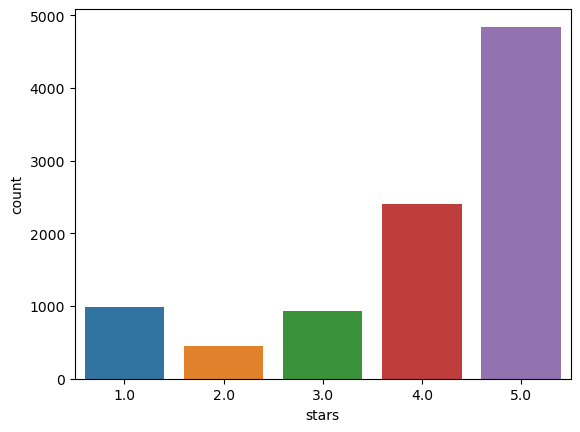

In [3]:
sns.countplot(train_df, x="stars")

### Load test data

In [4]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = set(stopwords.words('english'))
    custom_stopwords = {'not', 'is', 'but'}
    STOPWORDS -= custom_stopwords
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    # Split the reviews into words and remove stopwords
    words = reviews.split()
    words_filtered = [word for word in words if word not in STOPWORDS]
    
    # Join the filtered words back into a string
    filtered_reviews = ' '.join(words_filtered)
    
    return filtered_reviews

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review


def clean_text(data):

    data = data.apply(lower_case)
    data = data.apply(change_contractions)
    data = data.apply(remove_emojis)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_numbers)
    data = data.apply(remove_stopwords)
    data = data.apply(remove_extra_whitespace)
    data = data.apply(lemmaSentence)
    
    return data

def clean_text_withstopword(data):

    data = data.apply(lower_case)
    data = data.apply(change_contractions)
    data = data.apply(remove_emojis)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_numbers)
    #data = data.apply(remove_stopwords)
    data = data.apply(remove_extra_whitespace)
    data = data.apply(lemmaSentence)
    
    return data

In [49]:
testdf = pd.read_csv("eval.csv")

In [50]:
testdf['cleaned_text'] = clean_text(testdf.text)
def anno2binary(text):
    if text=='POSITIVE':
        return 1
    else:
        return 0
testdf['Binary_anno'] = testdf.Polarity_Anno1.apply(anno2binary)

### Assign polarity to train data
- Stars 4 and above, positive
- 1,2,3 stars, negative


In [51]:
#assign positive/negative labels method 1
train_df['sentiment'] = 0
train_df.loc[train_df['stars'] >=4, 'sentiment'] = 1 #positive

In [52]:
train_df_X = train_df['cleaned_text']
train_df_y = train_df['sentiment']

<Axes: xlabel='sentiment', ylabel='count'>

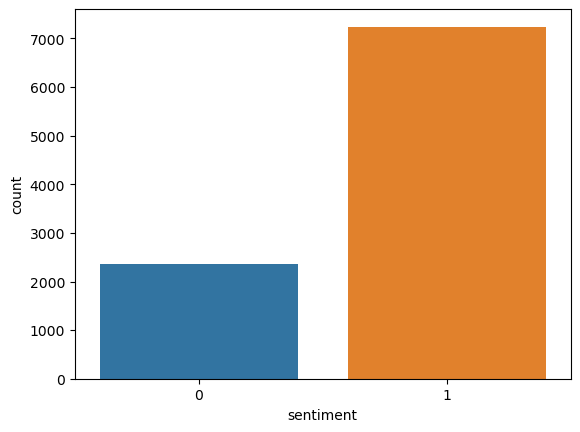

In [40]:
#visualize distribution. We must balance.
sns.countplot(train_df, x="sentiment")

### Demo of Word2vec Training
Train on Entire data https://stackoverflow.com/questions/77447526/word2vec-to-be-trained-on-train-data-or-whole-data

In [8]:
train_df_X_tok = train_df_X.apply(word_tokenize).to_list()

In [9]:
w2v_model = Word2Vec(min_count=5,
                     window=5,
                     sample=6e-5, 
                     alpha=0.025, 
                     min_alpha=0.0001, 
                     negative=5,
                     seed=42,
                     workers=18)

In [10]:
w2v_model.build_vocab(train_df_X_tok, progress_per=10000)

In [11]:
w2v_model.train(train_df_X_tok, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(6172433, 19065210)

In [12]:
w2v_model.wv.most_similar('tasty', topn=10)  # get other similar words

[('delicious', 0.8449707627296448),
 ('yummy', 0.7936611175537109),
 ('flavourful', 0.792464554309845),
 ('solid', 0.7906748056411743),
 ('gimbap', 0.789482831954956),
 ('japchae', 0.7393324375152588),
 ('generous', 0.7385523319244385),
 ('wellmarinated', 0.7327311038970947),
 ('appetising', 0.7193870544433594),
 ('marinated', 0.718366801738739)]

In [18]:
w2v_model.wv['tasty']

array([ 3.91677231e-01, -4.87983376e-01,  4.49636757e-01, -6.72886789e-01,
       -3.33438814e-02, -6.41418621e-02, -2.64323980e-01,  1.54634371e-01,
        1.76780745e-02,  4.92094070e-01, -3.83617610e-01,  3.57526988e-01,
       -3.03330004e-01, -7.63048008e-02,  1.89247102e-01, -5.90415359e-01,
       -3.01009566e-01, -3.31342965e-01, -5.41094661e-01, -6.00012243e-01,
        7.10519195e-01,  7.72076994e-02,  1.67802796e-01,  7.78253675e-01,
        2.53232926e-01,  1.64998591e-01, -9.25591648e-01, -3.47038209e-01,
        2.25415260e-01,  2.59039849e-01,  2.47793272e-02,  7.60424435e-01,
       -2.38322422e-01,  4.36126143e-01, -1.27677903e-01,  5.78171551e-01,
       -3.33585613e-03, -1.12549424e-01, -2.37591520e-01,  2.23436132e-01,
        5.09431541e-01, -1.19047545e-01, -1.30340710e-01,  5.23960888e-01,
        3.26660722e-01,  2.01577097e-01,  2.40842178e-01,  2.93012619e-01,
        2.40843281e-01, -5.17028272e-01, -4.64557141e-01, -2.82701701e-01,
        3.30643684e-01, -

In [14]:
train_df_X

0       this be my first time eat here i can tell you ...
1       consider that the din area be next to a prawn ...
2       st time come be month ago a decent cze char or...
3       first time experience prawn we spend a good hr...
4       outgo visit on saturday september fishing for ...
                              ...                        
9598    food portion be big in comparison to most tze ...
9599    affordable zichar stall locate in a coffeeshop...
9600    beef hor fan thick gravy savoury with beef sli...
9601    order chicken fry rice with extra egg and beef...
9602                     egg be tasty but oyster not good
Name: cleaned_text, Length: 9603, dtype: object

In [39]:
def convert_text2vec(text, w2v_model):
    vecs = []
    for word in text.split():
        if word in w2v_model.wv and word not in stopwords.words('english'):
            vecs.append(w2v_model.wv[word])
    
    if len(vecs)>0:
        return np.mean(vecs,axis=0)
    else:
        return np.zeros(100)

In [40]:
vecs = train_df_X.apply(convert_text2vec)
np.stack(vecs.values)

array([[ 0.35377362,  0.07539615, -0.04737797, ...,  0.06182289,
        -0.16208981,  0.04639178],
       [ 0.28550416, -0.17987567,  0.12997203, ..., -0.05489481,
        -0.00591396,  0.02173356],
       [ 0.26472116, -0.09528446,  0.00627039, ..., -0.09584538,
        -0.0700259 , -0.00199933],
       ...,
       [ 0.07458516, -0.70066637,  0.17170674, ..., -0.34141955,
         0.20200571,  0.13863602],
       [ 0.03509334, -0.60170221,  0.08558548, ..., -0.28042042,
         0.21617328,  0.0381618 ],
       [ 0.29852828, -0.51749307, -0.07067142, ..., -0.31900039,
        -0.08223026,  0.19606993]])

In [45]:
#train v2v and get vectors on the set
def w2v(train_df_X, ep):
    w2v_model = Word2Vec(min_count=5,
                     window=5,
                     sample=6e-5, 
                     alpha=0.025, 
                     min_alpha=0.0001, 
                     negative=5,
                     seed=42,
                     workers=18)
    train_df_X_tok = train_df_X.apply(word_tokenize).to_list()
    w2v_model.build_vocab(train_df_X_tok, progress_per=10000)
    w2v_model.train(train_df_X_tok, total_examples=w2v_model.corpus_count, epochs=ep, report_delay=1)
    vecs = train_df_X.apply(lambda x: convert_text2vec(x, w2v_model))
    return vecs, w2v_model

### Classification

In [14]:
#For gridsearching optimal hyperparameters
def max_key_for_max_value(dictionary):
    if not dictionary:  # If the dictionary is empty
        return None, None

    max_value = max(dictionary.values())  # Find the maximum value in the dictionary
    max_key = None

    for key, value in dictionary.items():
        if value == max_value:
            max_key = key

    return max_key, max_value

# Example usage:
my_dict = {'a': 10, 'b': 20, 'c': 20, 'd': 15}
max_key, max_value = max_key_for_max_value(my_dict)
print("Key with maximum value:", max_key)
print("Maximum value:", max_value)


Key with maximum value: c
Maximum value: 20


### Model 1: w2v + SVM

In [41]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'C': [0.5,1, 5, 10], 'kernel': ['rbf'], 'gamma':['scale','auto']}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for ep in [5,10,15,20,25,30]:
    #train w2v
    train_df_vecs, w2v_model = w2v(train_df_X,ep)

    for param in param_grid:
        param_f1 = []
        for train_index, test_index in kf.split(train_df_vecs, train_df_y):
            #split into train and val
            X_train, X_test = train_df_vecs[train_index],train_df_vecs[test_index]
            y_train, y_test = train_df_y[train_index], train_df_y[test_index]


            #Split into majority and minority for undersampling here
            X_train_majority_class = X_train[y_train == 1]
            y_train_majority_class = y_train[y_train == 1]
            X_train_minority_class = X_train[y_train == 0]
            y_train_minority_class = y_train[y_train == 0]

            # Downsample majority class only
            X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                            replace=False,    # sample without replacement
                                            n_samples=len(X_train_minority_class),   # to match minority class
                                            random_state=42)  # reproducible results

            # Combine minority class with downsampled majority class
            X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
            y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


            X_train_vector = np.stack(X_train_balanced.values)
            X_test_vector = np.stack(X_test.values)

            svc = svm.SVC(**param)
            svc.fit(X_train_vector, y_train_balanced)
            
            y_pred = svc.predict(X_test_vector)

            f1 = f1_score(y_test, y_pred, average='macro')
            param_f1.append(f1)
        param['ep'] = ep
        param_str = str(param)
        f1_scores[param_str] = mean(param_f1)
        print(param, ep)



{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 5} 5
{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 5} 5
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 5} 5
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 5} 5
{'C': 5, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 5} 5
{'C': 5, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 5} 5
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 5} 5
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 5} 5
{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 10} 10
{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 10} 10
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 10} 10
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 10} 10
{'C': 5, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 10} 10
{'C': 5, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 10} 10
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 10} 10
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 10} 10
{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf', 'ep': 15} 15
{'C': 0.5, 'gamma': 'auto', 'kernel': 'rb

In [43]:
max_key_for_max_value(f1_scores)

("{'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'ep': 30}", 0.8142020080337122)

In [77]:
# Fit optimal hyperparameters on entire train data
ep = 30
train_df_vecs, w2v_model = w2v(train_df_X,ep)
train_X = train_df_vecs

#Split into majority and minority for undersampling here
X_train_majority_class = train_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])

X_train_vector = np.stack(X_train_balanced.values)


svc = svm.SVC(C= 10, gamma= 'auto', kernel= 'rbf') #Optimal hyperparameters here
svc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = testdf.cleaned_text.apply(lambda x: convert_text2vec(x, w2v_model))
X_test_vector = np.stack(X_test_vector.values)
y_test_pred = svc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 3.766688346862793s


In [78]:
1068/(end-start)

283.53819101851576

In [60]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.58      0.91      0.71       220
           1       0.97      0.83      0.89       848

    accuracy                           0.84      1068
   macro avg       0.78      0.87      0.80      1068
weighted avg       0.89      0.84      0.86      1068



### Model 2: w2v + Random Forest

In [61]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'n_estimators': [100,200,250], 'max_depth':[5,10,20,None],'ccp_alpha':[0], 'max_features':['sqrt'],'n_jobs':[-1]}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for ep in [5,10,15,20,25,30]:
    #train w2v
    train_df_vecs, w2v_model = w2v(train_df_X,ep)

    for param in param_grid:
        param_f1 = []
        for train_index, test_index in kf.split(train_df_vecs, train_df_y):
            #split into train and val
            X_train, X_test = train_df_vecs[train_index],train_df_vecs[test_index]
            y_train, y_test = train_df_y[train_index], train_df_y[test_index]


            #Split into majority and minority for undersampling here
            X_train_majority_class = X_train[y_train == 1]
            y_train_majority_class = y_train[y_train == 1]
            X_train_minority_class = X_train[y_train == 0]
            y_train_minority_class = y_train[y_train == 0]

            # Downsample majority class only
            X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                            replace=False,    # sample without replacement
                                            n_samples=len(X_train_minority_class),   # to match minority class
                                            random_state=42)  # reproducible results

            # Combine minority class with downsampled majority class
            X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
            y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


            X_train_vector = np.stack(X_train_balanced.values)
            X_test_vector = np.stack(X_test.values)

            rfc = RandomForestClassifier(**param)
            rfc.fit(X_train_vector, y_train_balanced)
            
            y_pred = rfc.predict(X_test_vector)

            f1 = f1_score(y_test, y_pred, average='macro')
            param_f1.append(f1)
        param['ep'] = ep
        param_str = str(param)
        f1_scores[param_str] = mean(param_f1)
        print(param, ep)



{'ccp_alpha': 0, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 250, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 250, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 250, 'n_jobs': -1, 'ep': 30} 30
{'ccp_alpha': 0, 'max_depth': None, 'max_features

In [62]:
max_key_for_max_value(f1_scores)

("{'ccp_alpha': 0, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 250, 'n_jobs': -1, 'ep': 30}",
 0.8028815418999712)

In [79]:
# Fit optimal hyperparameters on entire train data
ep = 30
train_df_vecs, w2v_model = w2v(train_df_X,ep)
train_X = train_df_vecs

#Split into majority and minority for undersampling here
X_train_majority_class = train_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])

X_train_vector = np.stack(X_train_balanced.values)


rfc = RandomForestClassifier(ccp_alpha= 0, max_depth= 10, max_features= 'sqrt', n_estimators= 250, n_jobs= -1) #Optimal hyperparameters here
rfc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = testdf.cleaned_text.apply(lambda x: convert_text2vec(x, w2v_model))
X_test_vector = np.stack(X_test_vector.values)
y_test_pred = rfc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 3.5647997856140137s


In [80]:
1068/(end-start)

299.59606828691614

In [65]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.59      0.88      0.70       220
           1       0.96      0.84      0.90       848

    accuracy                           0.85      1068
   macro avg       0.78      0.86      0.80      1068
weighted avg       0.89      0.85      0.86      1068



### Model 3: W2V + Naive Bayes

In [72]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'alpha':[1]}
param_grid = ParameterGrid(param_grid)
f1_scores = {}
for ep in [5,10,15,20,25,30,40]:
    #train w2v
    train_df_vecs, w2v_model = w2v(train_df_X,ep)

    for param in param_grid:
        param_f1 = []
        for train_index, test_index in kf.split(train_df_vecs, train_df_y):
            #split into train and val
            X_train, X_test = train_df_vecs[train_index],train_df_vecs[test_index]
            y_train, y_test = train_df_y[train_index], train_df_y[test_index]


            #Split into majority and minority for undersampling here
            X_train_majority_class = X_train[y_train == 1]
            y_train_majority_class = y_train[y_train == 1]
            X_train_minority_class = X_train[y_train == 0]
            y_train_minority_class = y_train[y_train == 0]

            # Downsample majority class only
            X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                                            replace=False,    # sample without replacement
                                            n_samples=len(X_train_minority_class),   # to match minority class
                                            random_state=42)  # reproducible results

            # Combine minority class with downsampled majority class
            X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
            y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])


            X_train_vector = np.stack(X_train_balanced.values)
            X_test_vector = np.stack(X_test.values)
            
            scaler = MinMaxScaler()
            X_train_vector = scaler.fit_transform(X_train_vector)
            X_test_vector = scaler.transform(X_test_vector)
            nbc = MultinomialNB(**param)
            nbc.fit(X_train_vector, y_train_balanced)
            
            y_pred = nbc.predict(X_test_vector)

            f1 = f1_score(y_test, y_pred, average='macro')
            param_f1.append(f1)
        param['ep'] = ep
        param_str = str(param)
        f1_scores[param_str] = mean(param_f1)
        print(param, ep)



{'alpha': 1, 'ep': 5} 5
{'alpha': 1, 'ep': 10} 10
{'alpha': 1, 'ep': 15} 15
{'alpha': 1, 'ep': 20} 20
{'alpha': 1, 'ep': 25} 25
{'alpha': 1, 'ep': 30} 30
{'alpha': 1, 'ep': 40} 40


In [73]:
max_key_for_max_value(f1_scores)

("{'alpha': 1, 'ep': 40}", 0.7733665415202183)

In [83]:
# Fit optimal hyperparameters on entire train data
ep = 30
train_df_vecs, w2v_model = w2v(train_df_X,ep)
train_X = train_df_vecs

#Split into majority and minority for undersampling here
X_train_majority_class = train_X[train_df_y == 1]
y_train_majority_class = train_df_y[train_df_y == 1]
X_train_minority_class = train_X[train_df_y == 0]
y_train_minority_class = train_df_y[train_df_y == 0]

# Downsample majority class only
X_train_majority_downsampled,y_train_majority_downsampled = resample(X_train_majority_class,y_train_majority_class, 
                        replace=False,    # sample without replacement
                        n_samples=len(X_train_minority_class),   # to match minority class
                        random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority_class])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority_class])

X_train_vector = np.stack(X_train_balanced.values)

scaler = MinMaxScaler()
X_train_vector = scaler.fit_transform(X_train_vector)
X_test_vector = scaler.transform(X_test_vector)
nbc = MultinomialNB() #Optimal hyperparameters here
nbc.fit(X_train_vector, y_train_balanced)


#Apply fitted model to test
start = time()
X_test_vector = testdf.cleaned_text.apply(lambda x: convert_text2vec(x, w2v_model))
X_test_vector = np.stack(X_test_vector.values)
y_test_pred = nbc.predict(X_test_vector)
end = time()
y_test_gt = testdf.Binary_anno
print(f"Time taken to predict test set = {end-start}s")

Time taken to predict test set = 3.6200110912323s


In [84]:
1068/(end-start)

295.0267203840082

In [75]:
print(classification_report(y_test_gt, y_test_pred))

              precision    recall  f1-score   support

           0       0.40      0.95      0.56       220
           1       0.98      0.62      0.76       848

    accuracy                           0.69      1068
   macro avg       0.69      0.79      0.66      1068
weighted avg       0.86      0.69      0.72      1068

